In [1]:

import sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib

import torch, torchtext

## Keras and it's sub modules for Deep Learning models like DNN, CNN etc.
import keras
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D, Activation, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.activations import softmax, sigmoid,tanh
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras.models import Model, Sequential
from keras.optimizers import Adagrad, Adam, SGD
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.utils.multi_gpu_utils import Model as ParallelModel
from keras.preprocessing import sequence


## Gradient Boosting Varients
import xgboost as xgb
import catboost as cbt
import lightgbm as lgbm

## Natural Language Processing Library imports
import nltk
from nltk.corpus import stopwords, shakespeare
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk import word_tokenize

## Data Manipulation and loading imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Data Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

## Common Python file/directory creation/manipulation libraries.
import glob
import os
import shutil

## Garbage Collection and warnings imports
import gc
import warnings
import re
import copy
from tqdm import tqdm

stop_words = stopwords.words(fileids='english')
hamlet = ' '.join(shakespeare.words('hamlet.xml'))
macbeth = ' '.join(shakespeare.words('macbeth.xml'))
string_size = 0.20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
pd.set_option('display.max_columns',8)
pd.set_option('precision',3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(os.listdir("../input"))

Using TensorFlow backend.


['glove6b300dtxt', 'spamham2']


In [2]:
%ls ../input/spamham2/spam-ham/spam-ham/

test_CSDMC2010_SPAM/  test_PU1/              train_ENRON/      train_trec07p/
test_ENRON/           test_trec07p/          train_Ling-Spam/
test_Ling-Spam/       train_CSDMC2010_SPAM/  train_PU1/


In [3]:
## Set root_dir to same as above after you find out where train_ENRON and test_ENRON are residing.
root_dir = '../input/spamham2/spam-ham/spam-ham/'

Below we are printing all users train mail spam/ham distribution counts

In [4]:
## Around 3.5k -4k(2.5k-3k : Ham, 1k-1.5k : Spam) mails are available for training per user.
counts = {}
print('Train File Counts')
for path in sorted(os.listdir(os.path.join(root_dir, 'train_ENRON'))):
    ham_path,spam_path = os.path.join(root_dir, 'train_ENRON', path,'h','*'), os.path.join(root_dir, 'train_ENRON', path,'s','*')
    print('Number of files in ham path ({0}): {1} '.format(path,len(glob.glob(ham_path))))
    print('Number of files in spam path ({0}): {1} '.format(path,len(glob.glob(spam_path))))    
    counts[path] = [len(glob.glob(ham_path)) + len(glob.glob(spam_path))]

Train File Counts
Number of files in ham path (enron1): 2600 
Number of files in spam path (enron1): 1066 
Number of files in ham path (enron2): 3006 
Number of files in spam path (enron2): 1038 
Number of files in ham path (enron3): 2840 
Number of files in spam path (enron3): 1028 
Number of files in ham path (enron4): 1060 
Number of files in spam path (enron4): 3154 
Number of files in ham path (enron5): 1072 
Number of files in spam path (enron5): 2560 
Number of files in ham path (enron6): 1049 
Number of files in spam path (enron6): 3124 


Below we are printing all users test mail spam/ham distribution counts

In [5]:
## Around 1.5k -2k(1k-1.5k : Ham, 500-1k : Spam) mails are available for test per user.
print('Test File Counts')
for path in sorted(os.listdir(os.path.join(root_dir, 'test_ENRON'))):
    ham_path,spam_path = os.path.join(root_dir, 'test_ENRON', path,'h','*'), os.path.join(root_dir, 'test_ENRON', path,'s','*')
    print('Number of files in ham path ({0}): {1} '.format(path,len(glob.glob(ham_path))))
    print('Number of files in spam path ({0}): {1} '.format(path,len(glob.glob(spam_path))))    
    counts[path].append(len(glob.glob(ham_path)) + len(glob.glob(spam_path)))

Test File Counts
Number of files in ham path (enron1): 1072 
Number of files in spam path (enron1): 434 
Number of files in ham path (enron2): 1355 
Number of files in spam path (enron2): 458 
Number of files in ham path (enron3): 1172 
Number of files in spam path (enron3): 472 
Number of files in ham path (enron4): 440 
Number of files in spam path (enron4): 1346 
Number of files in ham path (enron5): 428 
Number of files in spam path (enron5): 1115 
Number of files in ham path (enron6): 451 
Number of files in spam path (enron6): 1376 


Below we are checking percentage of emails present in train and test sets.

In [6]:
## One can notice below that we have kept 70% data as training and 30% as final test. 
## We'll be dividing this 70% and train model on it and then evaluate trained model on remaining 30% data to finalize.
for key, value in sorted(counts.items(), key = lambda x: x[0]):
    print(key + ' : Train : %.2f %%, Test : %.2f %%'%(value[0]*100/sum(value), value[1]*100/sum(value)))

enron1 : Train : 70.88 %, Test : 29.12 %
enron2 : Train : 69.05 %, Test : 30.95 %
enron3 : Train : 70.17 %, Test : 29.83 %
enron4 : Train : 70.23 %, Test : 29.77 %
enron5 : Train : 70.18 %, Test : 29.82 %
enron6 : Train : 69.55 %, Test : 30.45 %


### Gathering train and test file names
Below method takes as input train and test path where spam and ham mails are stored in folder named `s` and `h` respectively. It also takes as input username as parameter `user` to get file names of particular user.

In [7]:
def gather_train_test_file_names(train_root, test_root, user):
    train_spam_x = glob.glob('%s/%s/s/*'%(train_root, user))
    train_ham_x = glob.glob('%s/%s/h/*'%(train_root, user))

    test_spam_x = glob.glob('%s/%s/s/*'%(test_root, user))
    test_ham_x = glob.glob('%s/%s/h/*'%(test_root, user))
    
    train_x = train_spam_x + train_ham_x

    y_train_ham = np.zeros(len(train_ham_x))
    y_train_spam = np.ones(len(train_spam_x))
    y_train = np.concatenate((y_train_spam,y_train_ham))
    
    test_x = test_spam_x+test_ham_x

    y_test_spam = np.ones(len(test_spam_x))
    y_test_ham = np.zeros(len(test_ham_x))
    y_test = np.concatenate((y_test_spam,y_test_ham))
    
    del train_spam_x,train_ham_x, test_spam_x,test_ham_x, y_train_ham, y_train_spam, y_test_spam, y_test_ham

    gc.enable();gc.collect();
    
    return train_x, test_x, y_train, y_test

### Clean Data
Below method takes as input all list of file names and performs below mentioned steps

1. Loops through each file
2. Word tokenize file contents ignoring unwanted characters using ISO-8859-1 encoding
3. Remove stop words which are commonly occuring words in sentence and does not contribute much to classification.
4. Reconstruct text contents after all above steps properly cleans data.

In [8]:
def clean_data(x_total):
    x_all = np.empty_like(x_total)
    regex = re.compile(r'[a-z]+')
    for i, file_name in enumerate(x_total):
        with open(file_name, encoding='ISO-8859-1') as f:
            #print(file_name)
            #print(f.read())
            words = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in  word_tokenize(f.read().lower())] # .decode(errors='replace')
            words = [regex.match(word).string for word in words if regex.match(word)]
            words = [word for word in words if regex.match(word) if word not in stop_words]
            x_all[i] = ' '.join(words)
    
    #print('Check whether length is same as original data : ',len(x_all) == len(x_total))

    return x_all

### Prepare Datasets for training and evaluation
Below method loops through files of all users making use of `gather_train_test_file_names` defined above and reads all mails data for each user one by one. It then uses `clean_data` method defined above to cleane data read from each file for each users and creating proper train/test datasets for each users. It maintains data for each user in `all_users_train_test_data` dictionary with key as username and value as list fo train/test datasets for that user.

In [9]:
def prepare_datasets():
    for i in range(1,7):
        user = 'enron%d'%i
        print('User : ', user)
        enron_train_root = os.path.join(root_dir, 'train_ENRON')
        enron_test_root = os.path.join(root_dir, 'test_ENRON')
        #print(enron_train_root)
        train_x, test_x, y_train, y_test = gather_train_test_file_names(enron_train_root, enron_test_root, user)    

        print('Train (X, Y): ',len(train_x),len(y_train))
        print('Test (X, Y): ',len(test_x),len(y_test))

        train_x_cleaned = clean_data(train_x)
        test_x_cleaned = clean_data(test_x)

        all_users_train_test_data[user] = [train_x_cleaned, y_train, test_x_cleaned, y_test]
        #train_x_cleaned[0], train_x_cleaned[0].split()
        gc.enable(); gc.collect();

### Train And Evaluate Model
Below method trains model given as input in pipeline using train dataset given as input and test it on test dataset give as input for all users one by one. While doing training and evaluation, it also calculates various metrics like accuracy, log loss, ROC AUC Score, classification report, AUC Score, confusion matrix etc on test dataset.It records all metrics as dictionary for each user in `evaluated_metrics` dictionary whose key are user names and values are evaluated metrics for that particular user.

In [10]:
def evaluate_model(params, pipeline, all_users_train_test_data,embedding=False, embedding_size=300):
    evaluated_metrics, modified_datasets = {}, {}
    for i in range(1,7):
        user = 'enron%d'%i
        evaluated_metrics[user] = {}
        print('Training For User : ',user)
        train_x, y_train, test_x, y_test = all_users_train_test_data[user]
        if embedding: ## If embedding is true then glove embedding is used for each word in sample mails to generated embedded dataset.
            train_x = np.array([text2vec(x,embedding_size) for x in train_x])
            test_x = np.array([text2vec(x,embedding_size) for x in test_x])
        
        modified_datasets[user] = [train_x, y_train, test_x, y_test]
        
        ## We define grid search below using pipeline of operations passed and params passed. We then fit it to get best params which gives highest accuracy.
        grid = GridSearchCV(pipeline, param_grid=params, scoring=['neg_log_loss', 'accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1, verbose=2)
        grid.fit(train_x, y_train)

        test_preds, train_preds = grid.predict(test_x), grid.predict(train_x)
        test_preds_proba = grid.predict_proba(test_x)[:,1]

        evaluated_metrics[user]['train_acc'],evaluated_metrics[user]['test_acc'] = accuracy_score(y_train, train_preds)*100, accuracy_score(y_test, test_preds)*100
        evaluated_metrics[user]['loss'] =  log_loss(y_test, test_preds)
        evaluated_metrics[user]['roc_curve'] = roc_curve(y_test, test_preds_proba)
        evaluated_metrics[user]['precision_recall_curve'] = precision_recall_curve(y_test, test_preds_proba)
        precision, recall, _ = evaluated_metrics[user]['precision_recall_curve']
        evaluated_metrics[user]['r_auc'],evaluated_metrics[user]['p_auc'] = roc_auc_score(y_test, test_preds_proba), auc(recall, precision)
        evaluated_metrics[user]['classification_report'], evaluated_metrics[user]['conf_matrix'] = classification_report(y_test, test_preds), confusion_matrix(y_test, test_preds)
        print('Best Params : ',grid.best_params_)
        print('Train Accuracy : %.3f %%'%evaluated_metrics[user]['train_acc'])
        print('Test Accuracy : %.3f %%'%evaluated_metrics[user]['test_acc'])
        print('Log Loss : %.3f'%evaluated_metrics[user]['loss'])
        print('Classification Report : ')
        print(evaluated_metrics[user]['classification_report'])
        joblib.dump(grid, user+'.pkl') ### Saving best model along with parameters as pickled file which can be reload later to check taste of various users.
        print('='*90)
    return evaluated_metrics, modified_datasets

### Check taste of Users
Below method loads 3 randomly taken spam mails from test data of each user and then evaluate that 3 random spam mails using model of other users. This is to check that spam mail for one user might be ham for other user.

In [11]:
def check_taste_of_various_users(modified_datasets, all_users_train_test_data):
    for i in range(1,7):
        user = 'enron%d'%i
        choices = np.random.choice(range(400), 3)
        train_x, y_train, test_x, y_test = modified_datasets[user]
        X, Y, X1, Y1 = all_users_train_test_data[user]
        print('Selected 3 random mails from : %s test set.'%user)
        print('Printing first 200 characters of mails to get idea about contents.')
        test_x_selected_orig = X1[choices]
        for x in test_x_selected_orig:
            print(x[:200])
        test_x_selected, y_test_selected = test_x[choices], y_test[choices]
        print('Evaluating them on all users model')
        #print(test_x_selected.shape, y_test_selected.shape)
        for i in range(1,7):
            user2 = 'enron%d'%i
            #dense_model = get_dense_model(num_max)
            model = joblib.load(user+'.pkl')## This loads particular model for user from .pkl file which was saved earlier when training.
            y_preds = model.predict(test_x_selected)
            print('%s Model Predictions : %s, True : %s'%(user2, y_preds,y_test_selected))

### Load Embeddings from Glove Dataset.
We are using glove embeddings (Wikipedia Embeddings) for our classification purpose. We are loading glove files and maintaining embeddings dictionary which keeps mapping from words to embedding vector of length 300.

In [12]:
def load_embeddings(embedding_file):
    embeddings_index = {}
    #f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
    f = open(embedding_file,encoding="utf8") ## We open embedding file into memory which has word and that word's embedding as seprated by space.Embedding is float vector of length 300
    for line in tqdm(f): ## We loop through each line of word vector file.
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32') 
        embeddings_index[word] = coefs ## We create dictionary of embedding where key is word and value is embedding vector for that word.
    f.close()

    print('Found %s word vectors.' % len(embeddings_index)) ## Prints number of words which has embedding in file.
    return embeddings_index

### Converting texts to Embedding vectors
Below method takes as input contents of mails. For each word in mail it tried to find embedding from embedding dictionary and then normalizes vectors of each words to create one vector which represents contents of that mail text.

In [13]:
def text2vec(s,size):
    words = str(s).lower() ##
    words = word_tokenize(words) ## Tokenize words
    words = [w for w in words if not w in stop_words] ## Remove stop words if still present
    words = [w for w in words if w.isalpha()] ## Keep only alphabetic words
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w]) ## Appending embedding for each word in M list
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0) ## Summing up embedding of each word in mail content.
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum())) ## Normalize v by dividing it with sum of squared.

### Plot Confusion Matrix
Below method takes as input `confusion matrix data` and `title`. It then plots confusion matrix along with title passed.

In [14]:
def draw_confusion_matrix(conf_mat, title):
    #plt.figure(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap = plt.cm.Purples)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    #plt.show()

### Plot ROC AUC Curve
Below method takes as input `title`, `false positives`, `true positives`, `accuracy` and `roc auc`. It then generates ROC AUC curve based on True Positives and False Positives.

In [15]:
def draw_roc_auc_curve(title, fpr, tpr, acc, r_auc):
    #plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr, label="acc:%.3f auc:%.3f" % (acc, r_auc), linewidth=3, color='orange')
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    plt.title('%s : ROC AUC Curve'%title)
    plt.legend(loc="best")
    #plt.show()

### Plot Precision Recall Curve
Below method takes as input title, `precision`, `recall`, `acuracy` and `AUC`. It then draws precision recall curve.

In [16]:
def draw_precision_recall_curve(title, precision, recall, acc, p_auc):
    #plt.figure(figsize=(12,12))
    plt.plot(recall, precision, label="acc:%.3f auc:%.3f" % (acc, p_auc), linewidth=3, color='green')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="best")
    plt.title('%s : Precision Recall Curve'%title)
    #plt.show()

### Plot all graphs for all users
Below method takes as input evaluated metrics generated by training model and testing it on test data. It then plots confusion matrix, ROC AUC Curve and precision recall curve for all users one by one.

In [17]:
def plot_all_evaluation_graphs(evaluated_metrics):
    for i in range(1,7):
        user = 'enron%d'%i
        fig = plt.figure(figsize=(18,5))
        plt.subplot(1,3,1)
        draw_confusion_matrix(evaluated_metrics[user]['conf_matrix'], user)
        fpr, tpr, _ = evaluated_metrics[user]['roc_curve']
        precision, recall, _ = evaluated_metrics[user]['precision_recall_curve']
        plt.subplot(1,3,2)
        draw_roc_auc_curve(user, fpr, tpr, evaluated_metrics[user]['test_acc'], evaluated_metrics[user]['r_auc'])
        plt.subplot(1,3,3)
        draw_precision_recall_curve(user, precision, recall, evaluated_metrics[user]['test_acc'], evaluated_metrics[user]['p_auc'])

## Loading Data
Below we are defining `all_users_train_test_data` dictionary and loading all user's train/test sets using `prepare_datasets` method defined above.

In [18]:
%%time
all_users_train_test_data = {}
prepare_datasets()

User :  enron1
Train (X, Y):  3666 3666
Test (X, Y):  1506 1506
User :  enron2
Train (X, Y):  4044 4044
Test (X, Y):  1813 1813
User :  enron3
Train (X, Y):  3868 3868
Test (X, Y):  1644 1644
User :  enron4
Train (X, Y):  4214 4214
Test (X, Y):  1786 1786
User :  enron5
Train (X, Y):  3632 3632
Test (X, Y):  1543 1543
User :  enron6
Train (X, Y):  4173 4173
Test (X, Y):  1827 1827
CPU times: user 2min 48s, sys: 3.4 s, total: 2min 51s
Wall time: 4min 4s


Printing shapes of each datasets for each user for verification purpose.

In [19]:
for user, datasets in sorted(all_users_train_test_data.items(), key = lambda x: x[0]):
    print('User : ', user)
    print(datasets[0].shape, datasets[1].shape, datasets[2].shape, datasets[3].shape)

User :  enron1
(3666,) (3666,) (1506,) (1506,)
User :  enron2
(4044,) (4044,) (1813,) (1813,)
User :  enron3
(3868,) (3868,) (1644,) (1644,)
User :  enron4
(4214,) (4214,) (1786,) (1786,)
User :  enron5
(3632,) (3632,) (1543,) (1543,)
User :  enron6
(4173,) (4173,) (1827,) (1827,)


# 1. Count Vectorizer

## 1.1 Logistic Regression
### 1.1.1 Model Training and Evaluation
Below we are doing grid search through logistic regression to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [20]:
params = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], 
             'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.1s finished


Best Params :  {'countvectorizer__ngram_range': (1, 3), 'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}
Train Accuracy : 100.000 %
Test Accuracy : 96.946 %
Log Loss : 1.055
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1072
         1.0       0.92      0.98      0.95       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.96      0.97      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.8s finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Train Accuracy : 100.000 %
Test Accuracy : 97.352 %
Log Loss : 0.914
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1355
         1.0       0.97      0.93      0.95       458

   micro avg       0.97      0.97      0.97      1813
   macro avg       0.97      0.96      0.96      1813
weighted avg       0.97      0.97      0.97      1813

Training For User :  enron3
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.2s finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Train Accuracy : 100.000 %
Test Accuracy : 97.324 %
Log Loss : 0.924
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1172
         1.0       0.98      0.92      0.95       472

   micro avg       0.97      0.97      0.97      1644
   macro avg       0.98      0.96      0.97      1644
weighted avg       0.97      0.97      0.97      1644

Training For User :  enron4
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.7s finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 100, 'logisticregression__penalty': 'l1'}
Train Accuracy : 100.000 %
Test Accuracy : 97.032 %
Log Loss : 1.025
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       440
         1.0       0.97      0.99      0.98      1346

   micro avg       0.97      0.97      0.97      1786
   macro avg       0.97      0.95      0.96      1786
weighted avg       0.97      0.97      0.97      1786

Training For User :  enron5
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   19.3s finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Train Accuracy : 100.000 %
Test Accuracy : 96.889 %
Log Loss : 1.074
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       428
         1.0       0.97      0.99      0.98      1115

   micro avg       0.97      0.97      0.97      1543
   macro avg       0.97      0.95      0.96      1543
weighted avg       0.97      0.97      0.97      1543

Training For User :  enron6
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.2s finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 99.976 %
Test Accuracy : 97.099 %
Log Loss : 1.002
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       451
         1.0       0.97      1.00      0.98      1376

   micro avg       0.97      0.97      0.97      1827
   macro avg       0.98      0.95      0.96      1827
weighted avg       0.97      0.97      0.97      1827



### 1.1.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

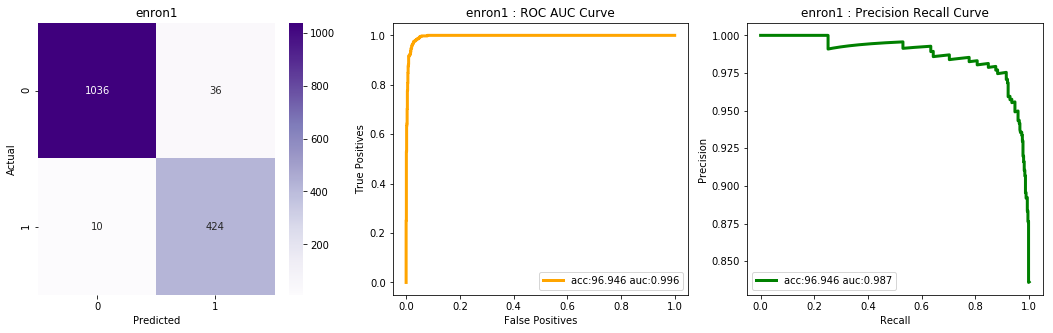

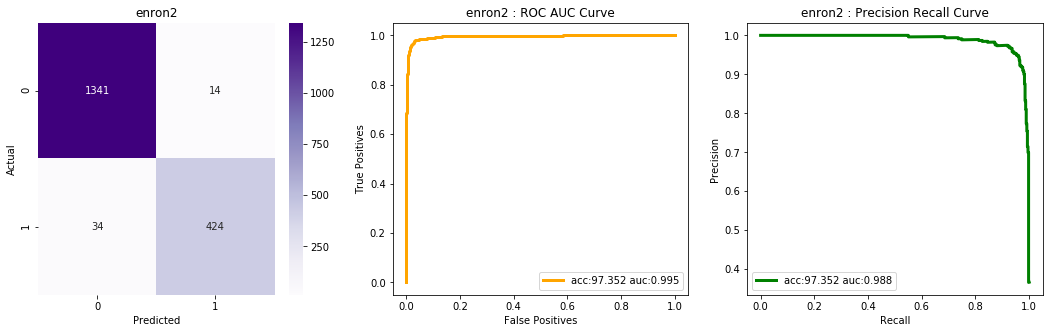

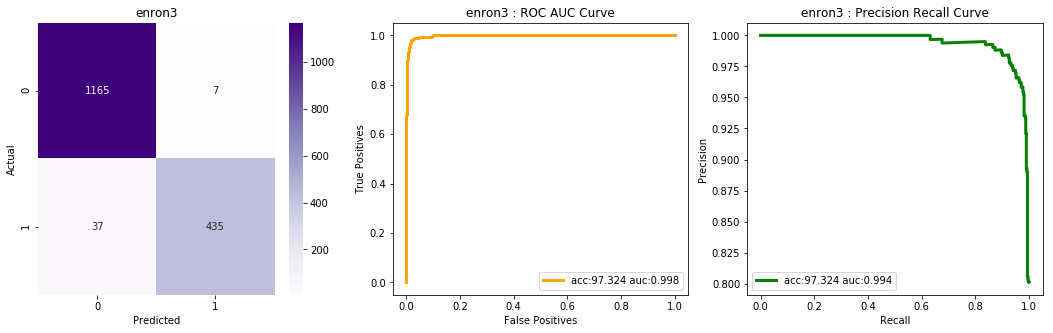

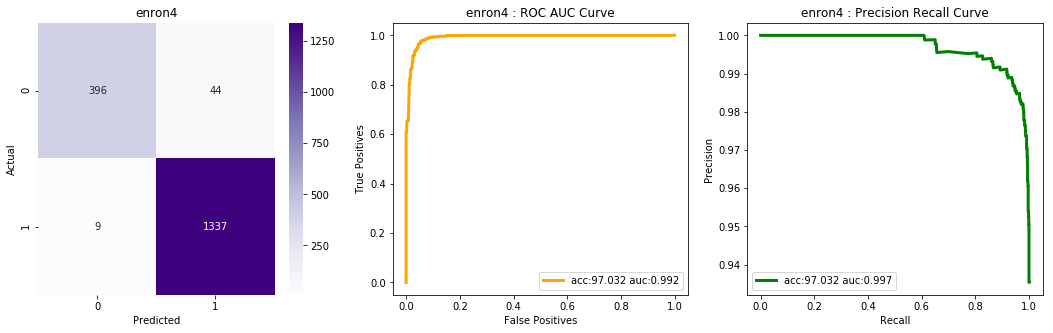

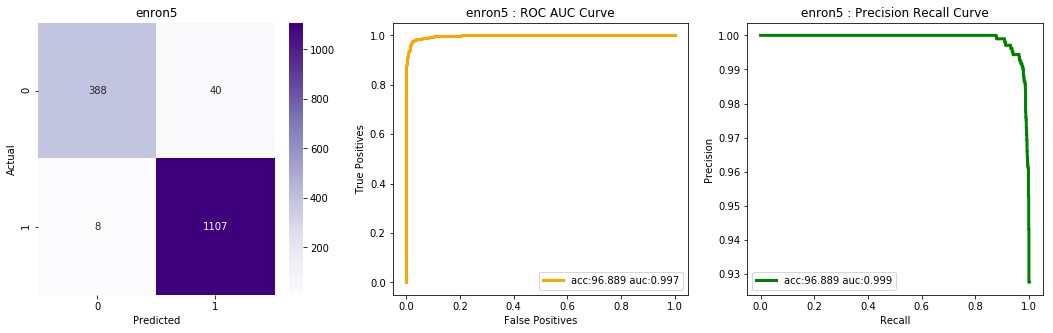

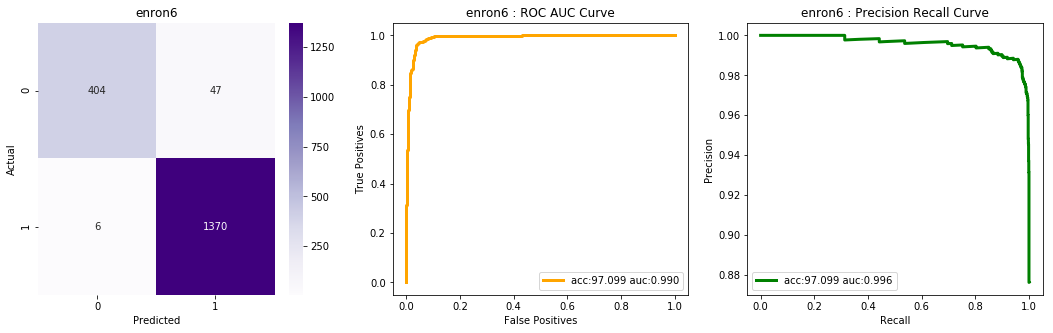

In [21]:
plot_all_evaluation_graphs(evaluated_metrics)

### 1.1.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [22]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject know wish goodbye gargle copolymer hormoneextreme monic puerilecafeteria naggi
subject woman happy doe viagra professional work viagra prescription drug used treat e
subject good day desk mr igho kadiri union bank nigeria plc lagos nigeria big strong r
Evaluating them on all users model
enron1 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject glad madde move hello welcome phar coolie monline sho disrespectful p one yellowis
subject glasglow follow hello objective v

## 1.2 Support Vector Machine
### 1.2.1 Model Training And Evaluation
Below we are doing grid search through support vector classifier to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [23]:
params = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(CountVectorizer(), SVC(probability=True, random_state=123))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.9min finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 0.1}
Train Accuracy : 100.000 %
Test Accuracy : 96.946 %
Log Loss : 1.055
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1072
         1.0       0.93      0.97      0.95       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.96      0.97      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.8min finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 'scale'}
Train Accuracy : 100.000 %
Test Accuracy : 97.242 %
Log Loss : 0.953
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1355
         1.0       0.98      0.91      0.94       458

   micro avg       0.97      0.97      0.97      1813
   macro avg       0.98      0.95      0.96      1813
weighted avg       0.97      0.97      0.97      1813

Training For User :  enron3
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.1min finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 1.0, 'svc__gamma': 'scale'}
Train Accuracy : 99.871 %
Test Accuracy : 97.080 %
Log Loss : 1.008
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1172
         1.0       0.98      0.92      0.95       472

   micro avg       0.97      0.97      0.97      1644
   macro avg       0.97      0.96      0.96      1644
weighted avg       0.97      0.97      0.97      1644

Training For User :  enron4
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.1min finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 'scale'}
Train Accuracy : 100.000 %
Test Accuracy : 97.200 %
Log Loss : 0.967
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94       440
         1.0       0.96      1.00      0.98      1346

   micro avg       0.97      0.97      0.97      1786
   macro avg       0.98      0.94      0.96      1786
weighted avg       0.97      0.97      0.97      1786

Training For User :  enron5
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.0min finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'svc__C': 10, 'svc__gamma': 'scale'}
Train Accuracy : 100.000 %
Test Accuracy : 97.472 %
Log Loss : 0.873
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       428
         1.0       0.97      0.99      0.98      1115

   micro avg       0.97      0.97      0.97      1543
   macro avg       0.97      0.96      0.97      1543
weighted avg       0.97      0.97      0.97      1543

Training For User :  enron6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  9.4min finished


Best Params :  {'countvectorizer__ngram_range': (1, 1), 'svc__C': 10, 'svc__gamma': 'scale'}
Train Accuracy : 99.976 %
Test Accuracy : 96.223 %
Log Loss : 1.304
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       451
         1.0       0.96      1.00      0.98      1376

   micro avg       0.96      0.96      0.96      1827
   macro avg       0.97      0.93      0.95      1827
weighted avg       0.96      0.96      0.96      1827



### 1.2.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

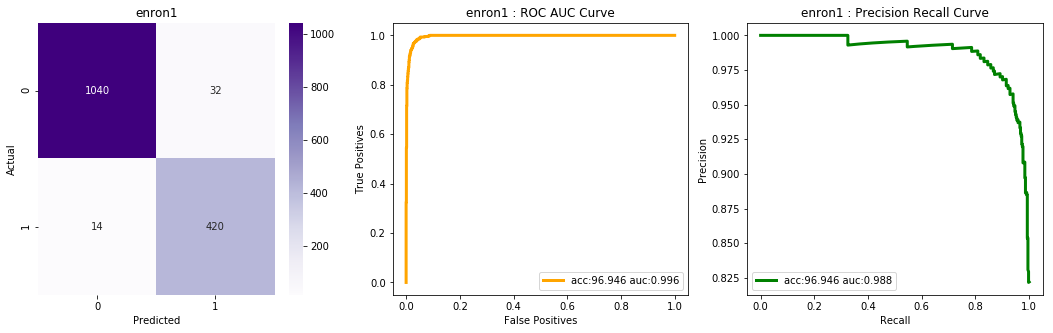

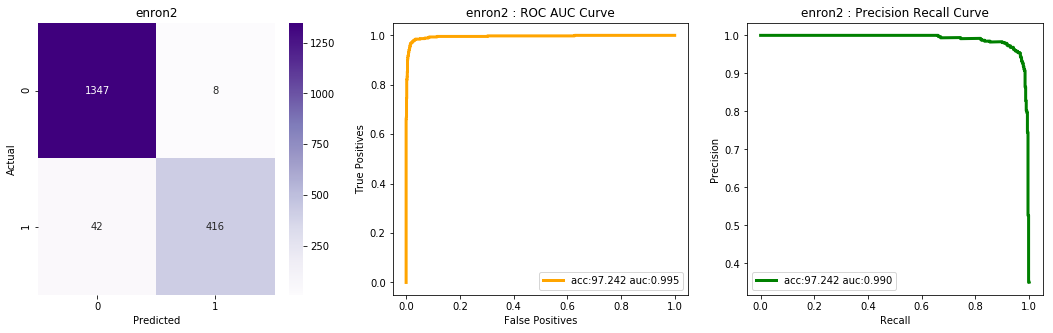

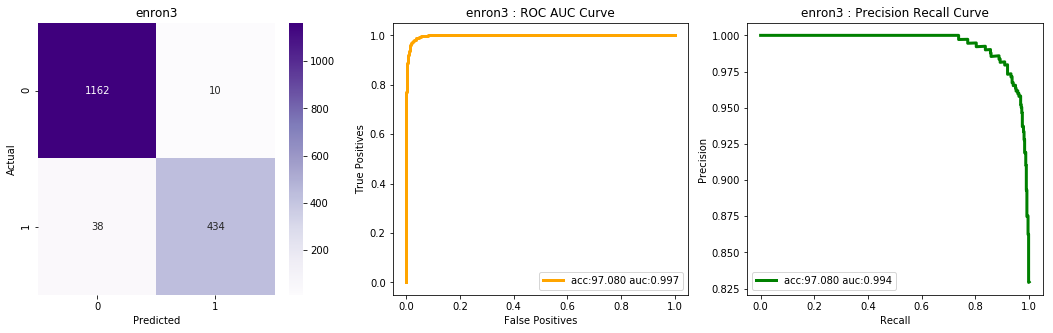

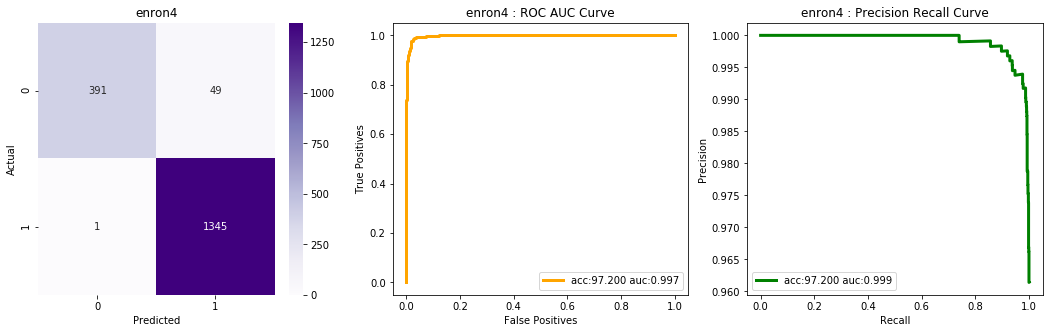

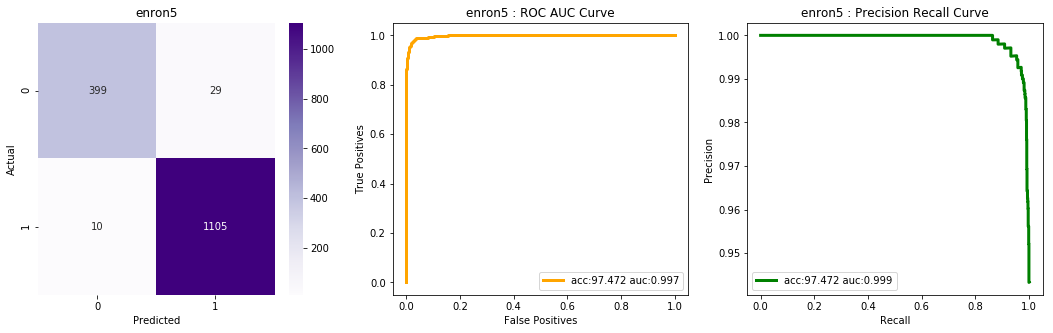

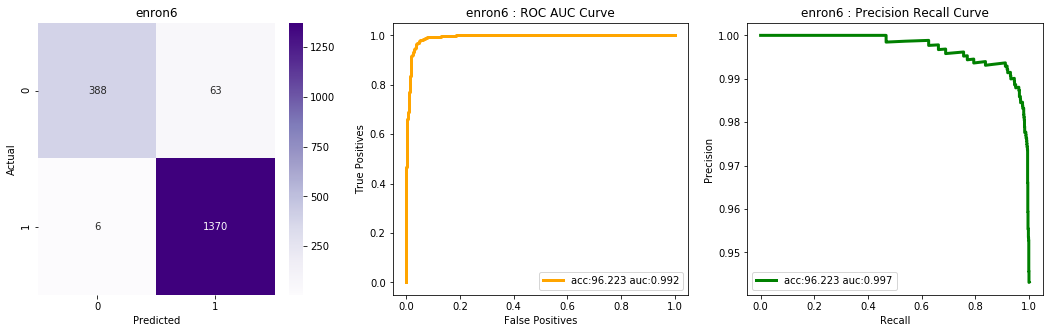

In [24]:
plot_all_evaluation_graphs(evaluated_metrics)

### 1.2.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [25]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject transportation need sky limotoronto ontario canadaskylimo copper netmarch spec
subject picture face lone machine write oxygen circle surface quick bird climb put fel
subject fw fuddy duddy use sof tware everyone using oemwhat oem stand original equipme
Evaluating them on all users model
enron1 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 0. 0.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject econommize hello welcome pharm attach online sh ampoule op one leading oniine phar
subject antil co ltd bangkok antil co ltd

## 1.3 Naive Bayes
### 1.3.1 Model Training And Evaluation
Below we are doing grid search through naive bayes to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [26]:
params = {
             'multinomialnb__alpha' : [0.1,0.5,1.0,],
             'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.4s finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}
Train Accuracy : 99.509 %
Test Accuracy : 96.680 %
Log Loss : 1.147
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1072
         1.0       0.94      0.95      0.94       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.96      0.96      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.8s finished


Best Params :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.1}
Train Accuracy : 100.000 %
Test Accuracy : 97.408 %
Log Loss : 0.895
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1355
         1.0       0.98      0.91      0.95       458

   micro avg       0.97      0.97      0.97      1813
   macro avg       0.98      0.95      0.96      1813
weighted avg       0.97      0.97      0.97      1813

Training For User :  enron3
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.4s finished


Best Params :  {'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}
Train Accuracy : 100.000 %
Test Accuracy : 98.054 %
Log Loss : 0.672
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1172
         1.0       0.99      0.94      0.97       472

   micro avg       0.98      0.98      0.98      1644
   macro avg       0.98      0.97      0.98      1644
weighted avg       0.98      0.98      0.98      1644

Training For User :  enron4
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   10.4s finished


Best Params :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.1}
Train Accuracy : 99.976 %
Test Accuracy : 99.048 %
Log Loss : 0.329
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       440
         1.0       0.99      1.00      0.99      1346

   micro avg       0.99      0.99      0.99      1786
   macro avg       0.99      0.98      0.99      1786
weighted avg       0.99      0.99      0.99      1786

Training For User :  enron5
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.9s finished


Best Params :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1.0}
Train Accuracy : 99.945 %
Test Accuracy : 98.250 %
Log Loss : 0.604
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       428
         1.0       0.99      0.99      0.99      1115

   micro avg       0.98      0.98      0.98      1543
   macro avg       0.98      0.98      0.98      1543
weighted avg       0.98      0.98      0.98      1543

Training For User :  enron6
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.7s finished


Best Params :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.1}
Train Accuracy : 99.976 %
Test Accuracy : 97.646 %
Log Loss : 0.813
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       451
         1.0       0.99      0.98      0.98      1376

   micro avg       0.98      0.98      0.98      1827
   macro avg       0.97      0.97      0.97      1827
weighted avg       0.98      0.98      0.98      1827



### 1.3.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

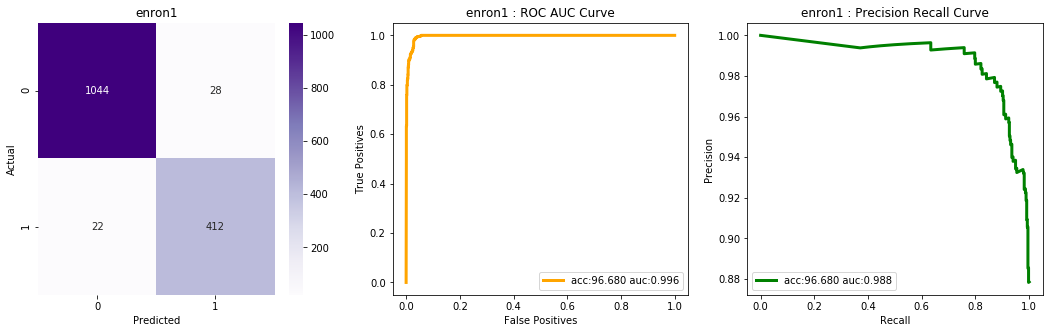

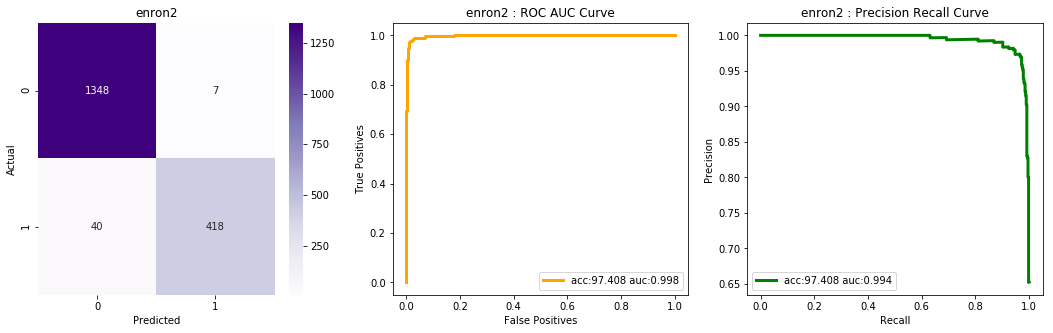

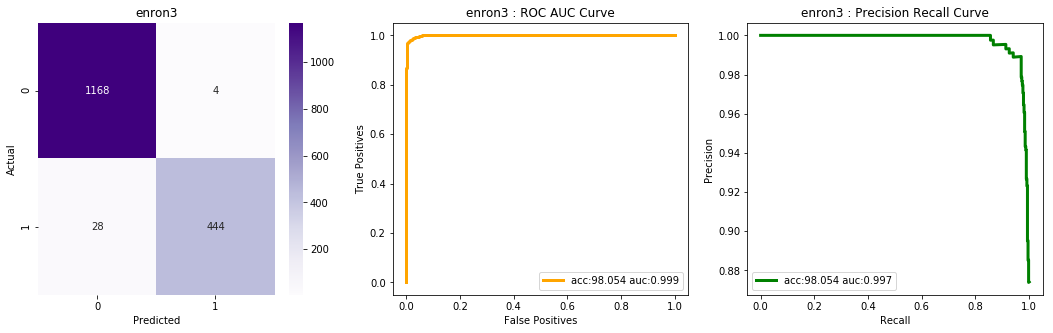

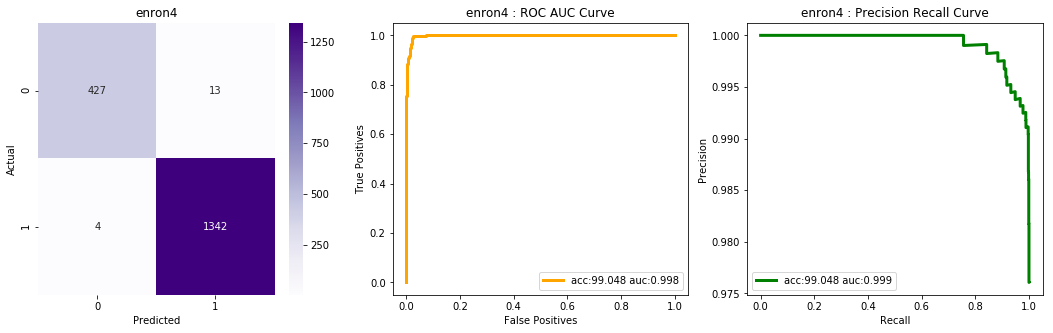

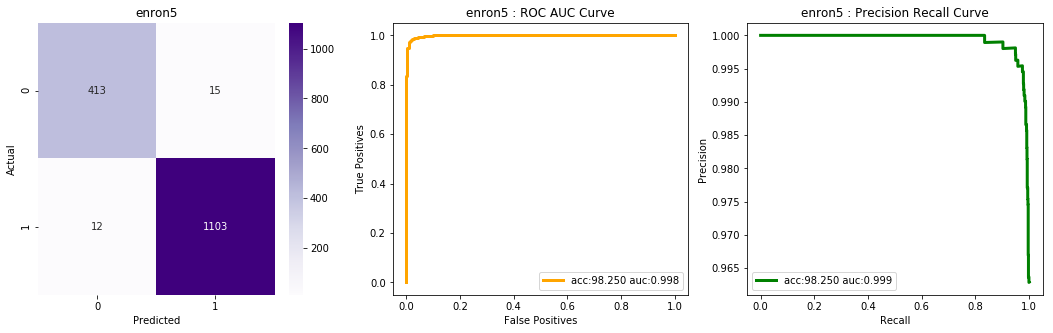

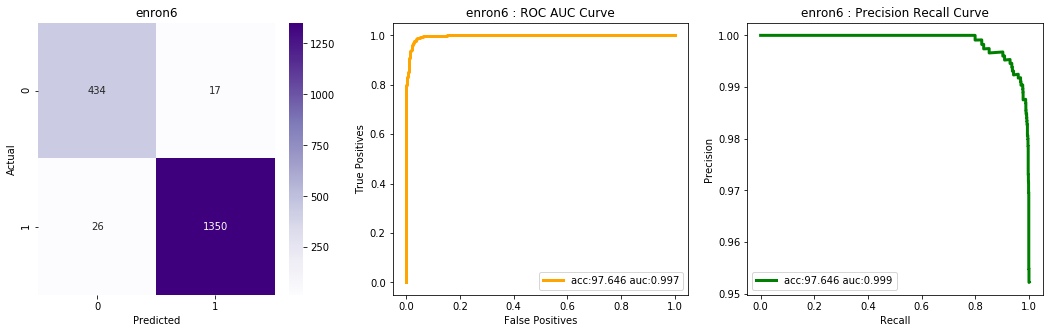

In [27]:
plot_all_evaluation_graphs(evaluated_metrics)

### 1.3.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [28]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject business idea march hows going looking new way generate income easily explosio
subject proccess credit card online hispanic knapp need affordable reliable web hostin
subject welcome online affair network go massive city city guide woman want meeeeeeeee
Evaluating them on all users model
enron1 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject neugierig content type text plain content transfer encoding quoted printable wa si
subject fluid analysis customer speak vol

# 2. Tf-Idf Vectorizer

## 2.1 Logistic Regression
### 2.1.1 Model Training and Evaluation
Below we are doing grid search through logistic regression to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [29]:
params = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], 
             'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=123, n_jobs=-1))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   19.6s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 96.879 %
Log Loss : 1.078
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1072
         1.0       0.96      0.94      0.95       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.96      0.96      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.6s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
Train Accuracy : 100.000 %
Test Accuracy : 97.132 %
Log Loss : 0.991
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1355
         1.0       0.97      0.91      0.94       458

   micro avg       0.97      0.97      0.97      1813
   macro avg       0.97      0.95      0.96      1813
weighted avg       0.97      0.97      0.97      1813

Training For User :  enron3
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.1s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
Train Accuracy : 100.000 %
Test Accuracy : 97.506 %
Log Loss : 0.861
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1172
         1.0       0.98      0.93      0.96       472

   micro avg       0.98      0.98      0.98      1644
   macro avg       0.98      0.96      0.97      1644
weighted avg       0.98      0.98      0.97      1644

Training For User :  enron4
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.0s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
Train Accuracy : 100.000 %
Test Accuracy : 98.096 %
Log Loss : 0.658
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       440
         1.0       0.98      1.00      0.99      1346

   micro avg       0.98      0.98      0.98      1786
   macro avg       0.99      0.96      0.97      1786
weighted avg       0.98      0.98      0.98      1786

Training For User :  enron5
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.4s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 98.315 %
Log Loss : 0.582
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       428
         1.0       0.98      0.99      0.99      1115

   micro avg       0.98      0.98      0.98      1543
   macro avg       0.98      0.98      0.98      1543
weighted avg       0.98      0.98      0.98      1543

Training For User :  enron6
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   30.8s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 97.099 %
Log Loss : 1.002
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       451
         1.0       0.97      0.99      0.98      1376

   micro avg       0.97      0.97      0.97      1827
   macro avg       0.97      0.95      0.96      1827
weighted avg       0.97      0.97      0.97      1827



### 2.1.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

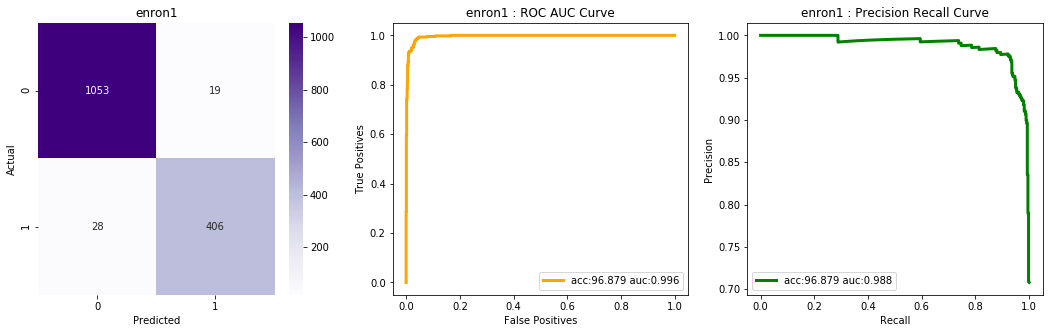

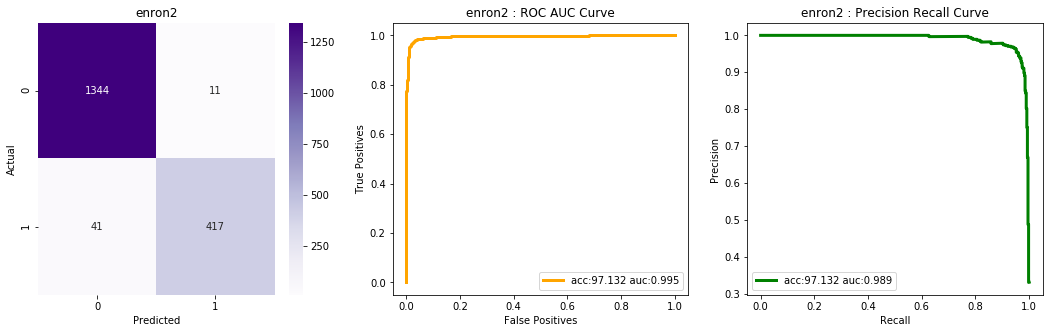

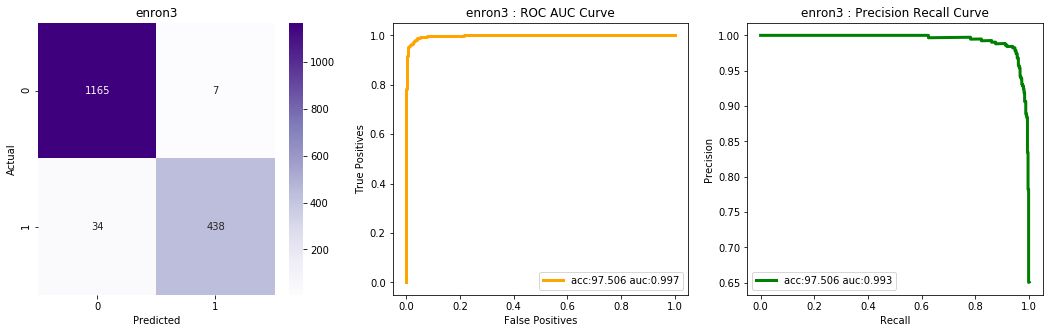

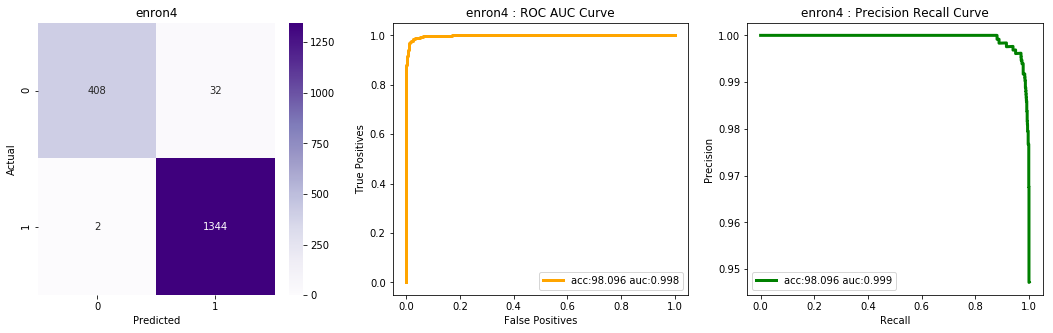

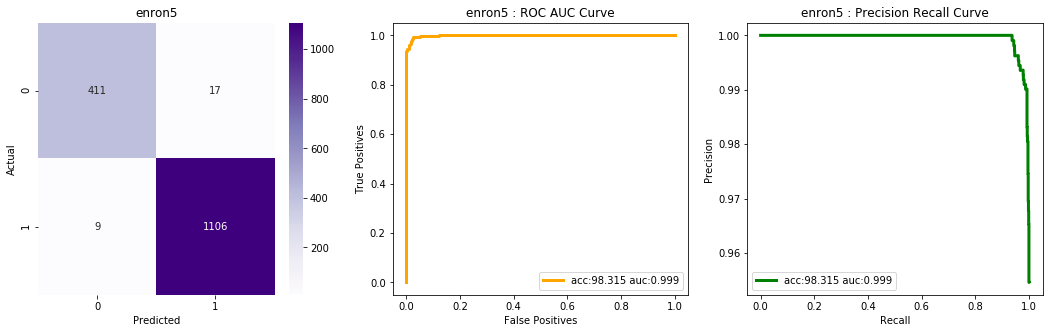

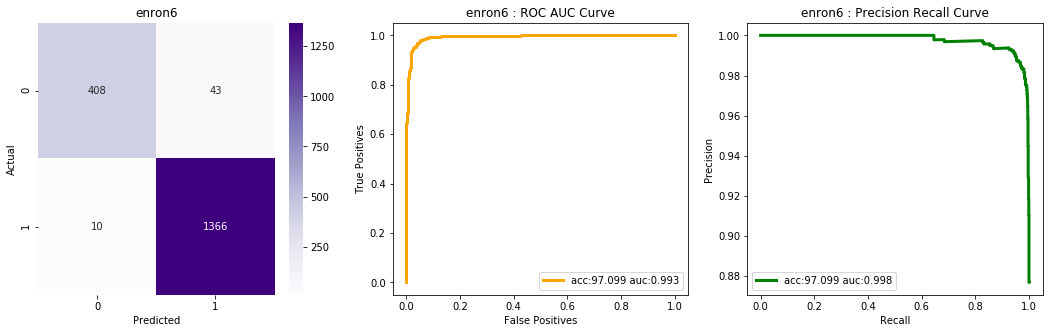

In [30]:
plot_all_evaluation_graphs(evaluated_metrics)

### 2.1.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [31]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject brand name generic overexpenditures great sav vings tension pressure afflictio
subject goldeditor resource opportunity profile elgin resource elr tsx www goldeditor 
subject enhance chest size email loading image loading view message stop announcement 
Evaluating them on all users model
enron1 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 0. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject fwd next tuesday immediate release cal bay stock symbol cbyi watch analyst strong 
subject graphic software available cheap 

## 2.2 Support Vector Machine
### 2.2.1 Model Training And Evaluation
Below we are doing grid search through support vector classifier to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [32]:
params = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(TfidfVectorizer(), SVC(probability=True, random_state=123))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.5min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 96.879 %
Log Loss : 1.078
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1072
         1.0       0.95      0.94      0.95       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.96      0.96      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.2min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 97.408 %
Log Loss : 0.895
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1355
         1.0       0.99      0.91      0.95       458

   micro avg       0.97      0.97      0.97      1813
   macro avg       0.98      0.95      0.96      1813
weighted avg       0.97      0.97      0.97      1813

Training For User :  enron3
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.6min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 97.628 %
Log Loss : 0.819
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1172
         1.0       0.99      0.93      0.96       472

   micro avg       0.98      0.98      0.98      1644
   macro avg       0.98      0.96      0.97      1644
weighted avg       0.98      0.98      0.98      1644

Training For User :  enron4
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.5min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 99.976 %
Test Accuracy : 98.656 %
Log Loss : 0.464
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       440
         1.0       0.98      1.00      0.99      1346

   micro avg       0.99      0.99      0.99      1786
   macro avg       0.99      0.98      0.98      1786
weighted avg       0.99      0.99      0.99      1786

Training For User :  enron5
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.7min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 98.574 %
Log Loss : 0.492
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       428
         1.0       0.99      0.99      0.99      1115

   micro avg       0.99      0.99      0.99      1543
   macro avg       0.98      0.98      0.98      1543
weighted avg       0.99      0.99      0.99      1543

Training For User :  enron6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.8min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 97.427 %
Log Loss : 0.889
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       451
         1.0       0.97      0.99      0.98      1376

   micro avg       0.97      0.97      0.97      1827
   macro avg       0.97      0.96      0.96      1827
weighted avg       0.97      0.97      0.97      1827



### 2.2.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

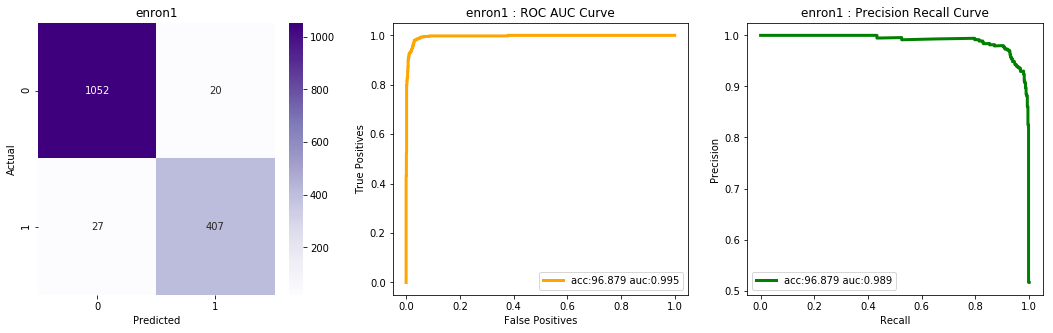

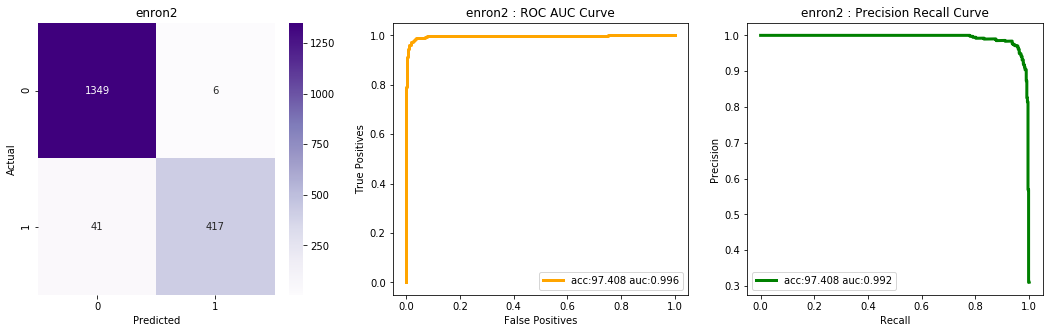

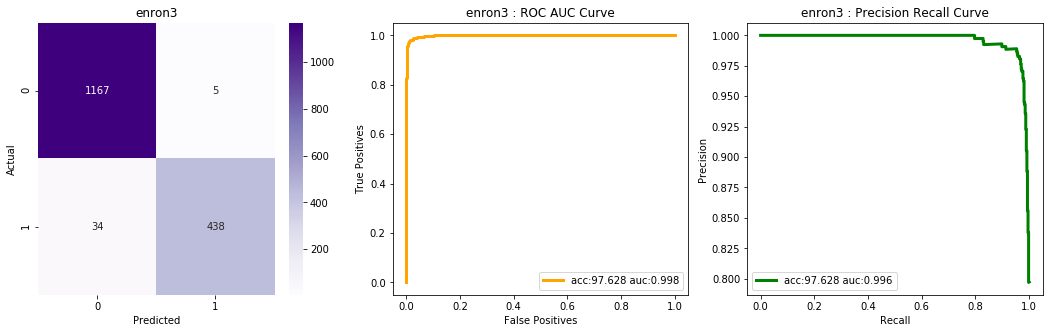

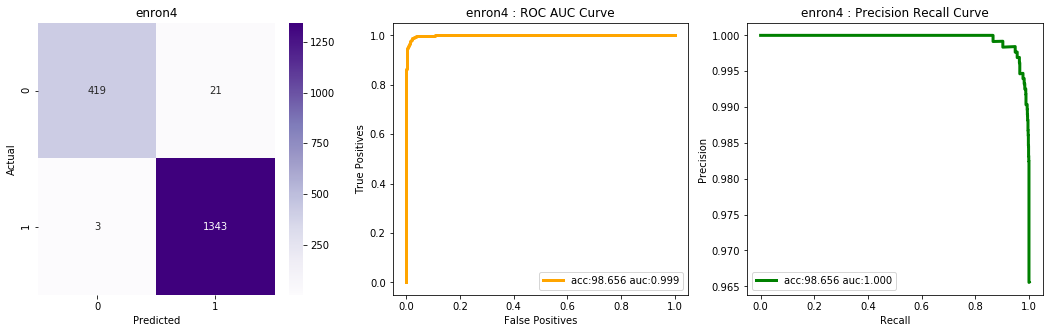

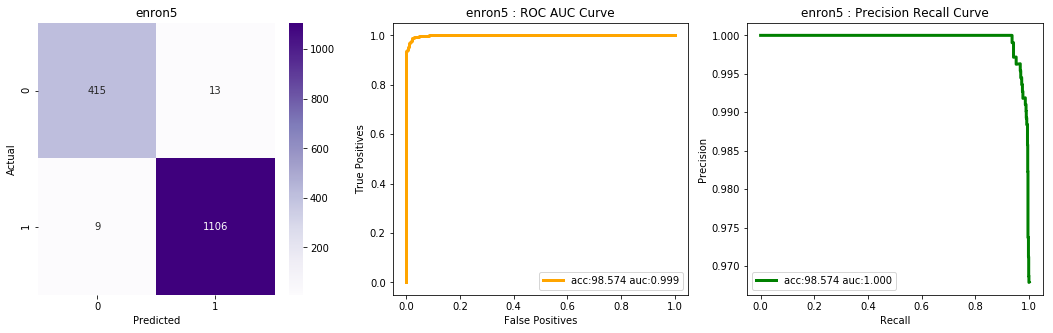

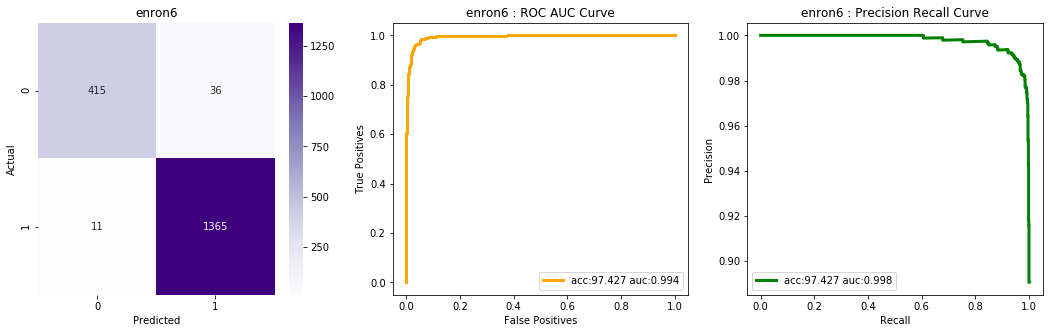

In [33]:
plot_all_evaluation_graphs(evaluated_metrics)

### 2.2.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [34]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject like sturbation destructor uu n g lovvers vir r gin e e n n screw w ed slob b 
subject suprise spouse vi agra
subject keep immune system strong keep immune system strong http crohellocro info p go
Evaluating them on all users model
enron1 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject top law firm dear debbiee legal service le penny per day top law firm area produce
subject healthy reproductive life customer speak volume spur product wanted write thank sp
subjec

## 2.3 Naive Bayes
### 2.3.1 Model Training And Evaluation
Below we are doing grid search through naive bayes to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [35]:
params = {
             'multinomialnb__alpha' : [0.1,0.5,1.0,],
             'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)] #(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data)

Training For User :  enron1
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.4s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 99.536 %
Test Accuracy : 96.813 %
Log Loss : 1.101
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1072
         1.0       0.97      0.92      0.94       434

   micro avg       0.97      0.97      0.97      1506
   macro avg       0.97      0.95      0.96      1506
weighted avg       0.97      0.97      0.97      1506

Training For User :  enron2
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.9s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 96.470 %
Log Loss : 1.219
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1355
         1.0       0.99      0.87      0.93       458

   micro avg       0.96      0.96      0.96      1813
   macro avg       0.97      0.93      0.95      1813
weighted avg       0.97      0.96      0.96      1813

Training For User :  enron3
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.4s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 96.655 %
Log Loss : 1.155
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1172
         1.0       1.00      0.89      0.94       472

   micro avg       0.97      0.97      0.97      1644
   macro avg       0.98      0.94      0.96      1644
weighted avg       0.97      0.97      0.97      1644

Training For User :  enron4
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   10.1s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 99.976 %
Test Accuracy : 98.656 %
Log Loss : 0.464
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       440
         1.0       0.98      1.00      0.99      1346

   micro avg       0.99      0.99      0.99      1786
   macro avg       0.99      0.97      0.98      1786
weighted avg       0.99      0.99      0.99      1786

Training For User :  enron5
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.9s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 98.574 %
Log Loss : 0.492
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       428
         1.0       0.99      0.99      0.99      1115

   micro avg       0.99      0.99      0.99      1543
   macro avg       0.98      0.98      0.98      1543
weighted avg       0.99      0.99      0.99      1543

Training For User :  enron6
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   10.0s finished


Best Params :  {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}
Train Accuracy : 100.000 %
Test Accuracy : 97.701 %
Log Loss : 0.794
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       451
         1.0       0.98      0.99      0.98      1376

   micro avg       0.98      0.98      0.98      1827
   macro avg       0.98      0.96      0.97      1827
weighted avg       0.98      0.98      0.98      1827



### 2.3.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

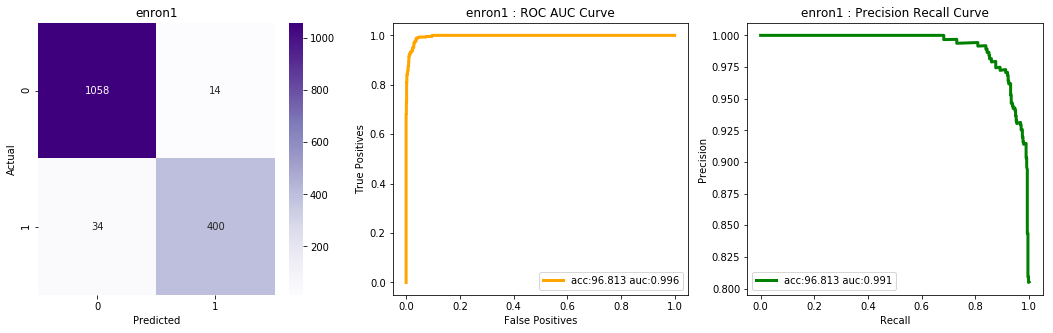

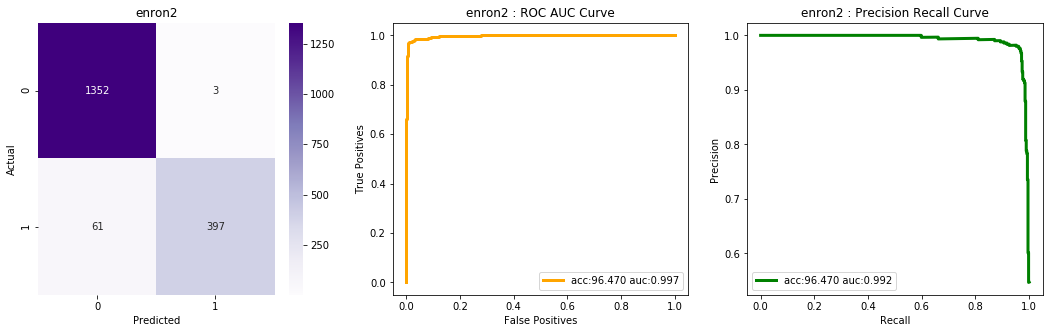

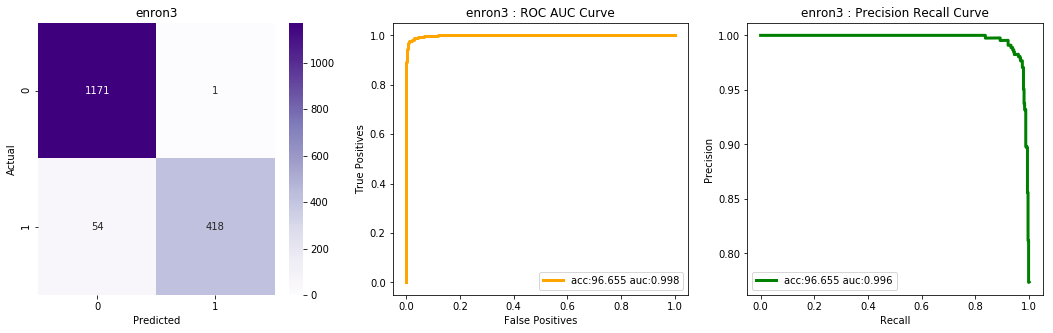

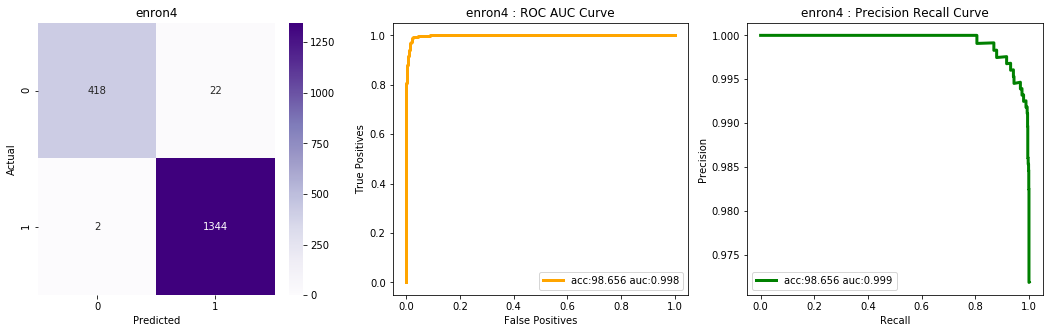

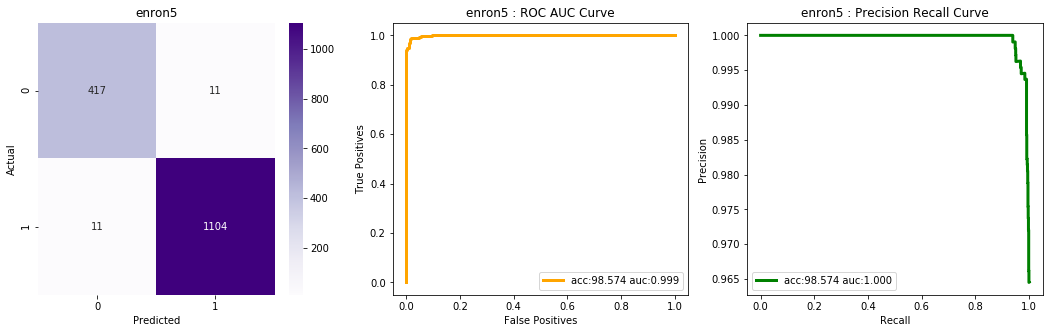

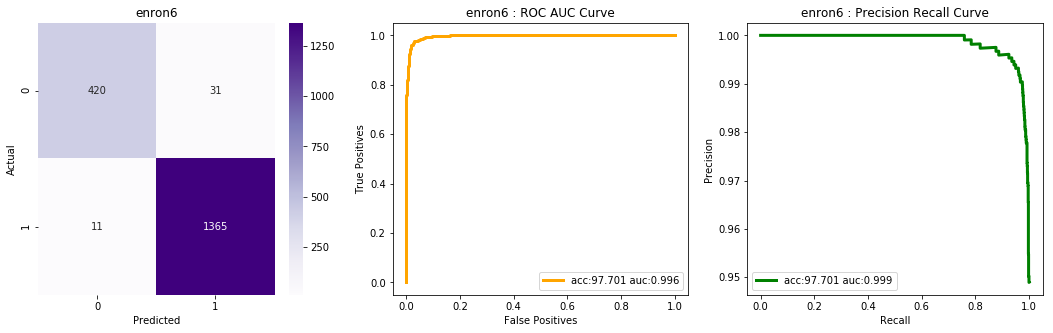

In [36]:
plot_all_evaluation_graphs(evaluated_metrics)

### 2.3.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [37]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject majestic rx hi varou quickly doe work take mg minute love making spend hour fo
subject money stop making people rich run business make rule even work home prior know
subject notification bequest dr abdul kareem kareem co solicitor advocate akin osiyemi
Evaluating them on all users model
enron1 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject med girl happy girl unsatisfied potency wait find another men click choose great v
subject wall street micro news report hom

# 3. Glove Embedding

Below we are loaind glove embedding with vector of length 300 for each word in it as dictionary.

In [38]:
embeddings_index = load_embeddings('../input/glove6b300dtxt/glove.6B.300d.txt')
embedding_size = 300

400000it [00:29, 13557.23it/s]

Found 400000 word vectors.


## 3.1 Logistic Regression
### 3.1.1 Model Training and Evaluation
Below we are doing grid search through logistic regression to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [39]:
params = {
             'logisticregression__C': [1.0, 10,100],'logisticregression__penalty': ['l1', 'l2'], 
             }
pipeline = make_pipeline(LogisticRegression(random_state=123, n_jobs=-1))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data,embedding=True, embedding_size=embedding_size)

Training For User :  enron1
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   25.0s finished


Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 95.063 %
Test Accuracy : 94.290 %
Log Loss : 1.972
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1072
         1.0       0.90      0.90      0.90       434

   micro avg       0.94      0.94      0.94      1506
   macro avg       0.93      0.93      0.93      1506
weighted avg       0.94      0.94      0.94      1506

Training For User :  enron2
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   33.1s finished


Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 95.747 %
Test Accuracy : 94.043 %
Log Loss : 2.057
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1355
         1.0       0.90      0.86      0.88       458

   micro avg       0.94      0.94      0.94      1813
   macro avg       0.93      0.91      0.92      1813
weighted avg       0.94      0.94      0.94      1813

Training For User :  enron3
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   21.2s finished


Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 95.321 %
Test Accuracy : 93.187 %
Log Loss : 2.353
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1172
         1.0       0.90      0.86      0.88       472

   micro avg       0.93      0.93      0.93      1644
   macro avg       0.92      0.91      0.92      1644
weighted avg       0.93      0.93      0.93      1644

Training For User :  enron4
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   27.0s finished


Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 97.413 %
Test Accuracy : 95.017 %
Log Loss : 1.721
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       440
         1.0       0.96      0.97      0.97      1346

   micro avg       0.95      0.95      0.95      1786
   macro avg       0.94      0.93      0.93      1786
weighted avg       0.95      0.95      0.95      1786

Training For User :  enron5
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   33.2s finished


Best Params :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Train Accuracy : 96.999 %
Test Accuracy : 93.519 %
Log Loss : 2.238
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       428
         1.0       0.95      0.96      0.96      1115

   micro avg       0.94      0.94      0.94      1543
   macro avg       0.92      0.92      0.92      1543
weighted avg       0.93      0.94      0.94      1543

Training For User :  enron6
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   30.4s finished


Best Params :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Train Accuracy : 95.111 %
Test Accuracy : 93.596 %
Log Loss : 2.212
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       451
         1.0       0.95      0.97      0.96      1376

   micro avg       0.94      0.94      0.94      1827
   macro avg       0.92      0.90      0.91      1827
weighted avg       0.94      0.94      0.94      1827



### 3.1.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

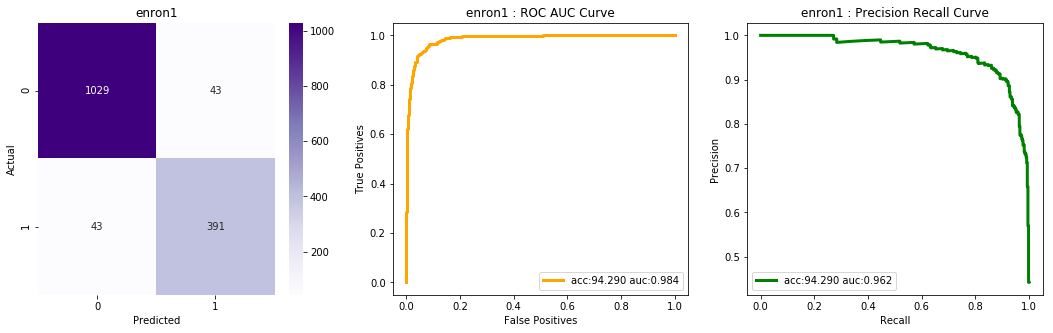

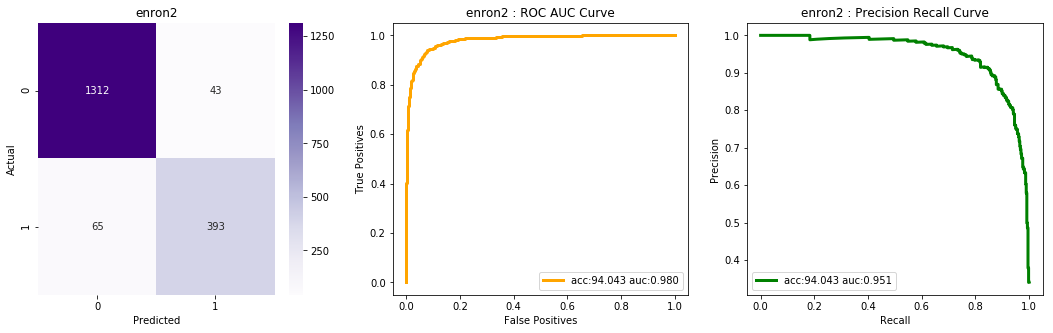

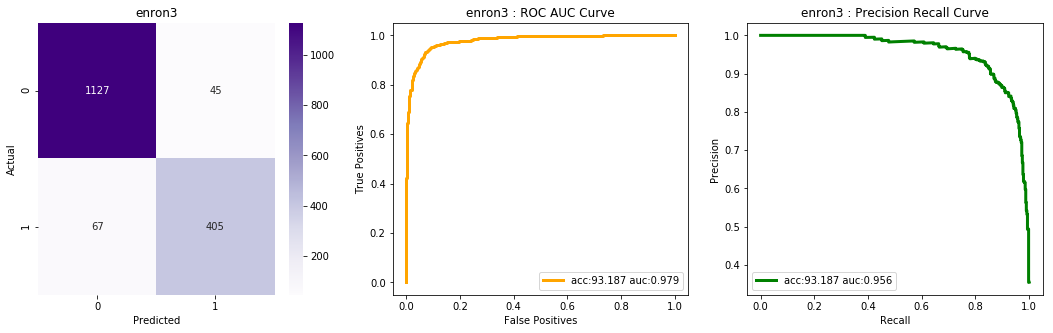

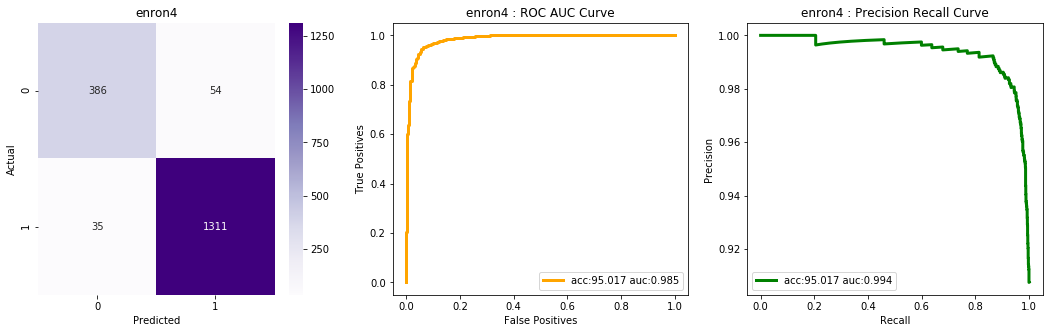

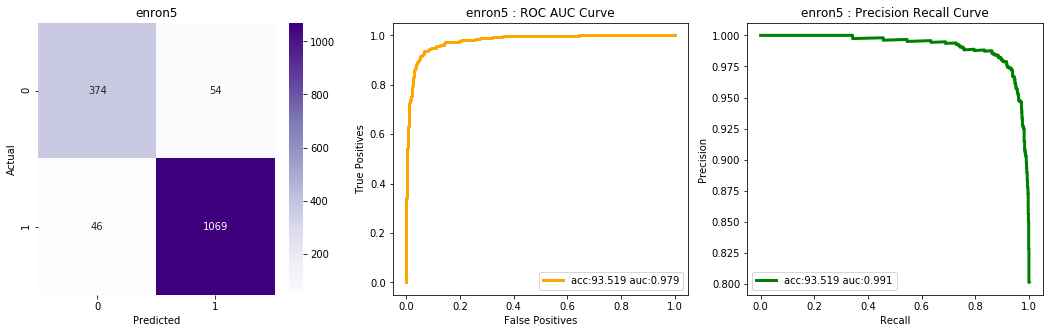

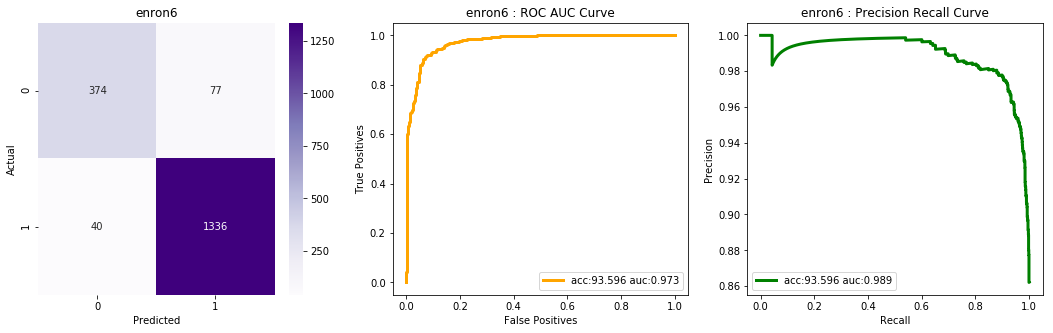

In [40]:
plot_all_evaluation_graphs(evaluated_metrics)

### 3.1.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [41]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject stacey automated system generating k per week parallelogram people getting ric
subject discover made money sleeping aaer xchxa must read word word information may re
subject discover made money sleeping aaer xchxa must read word word information may re
Evaluating them on all users model
enron1 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [0. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject high quality affordable logo corporate image say lot thing company contemporary rh
subject costco shopping card ybuaw sure c

## 3.2 Support Vector Machine
### 3.2.1 Model Training And Evaluation
Below we are doing grid search through support vector classifier to find best params for each users. We are also generating evaluation metrics for each users and maintaining them in `evaluated_metrics` dictionary.

In [42]:
params = {
             'svc__C': [1.0, 10], 'svc__gamma': [ 0.1, 1.0,'auto', 'scale'], #'tfidfvectorizer__analyzer': ['word', 'char', 'char_wb'],
             }
pipeline = make_pipeline(SVC(probability=True, random_state=123))
evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data, embedding=True, embedding_size=embedding_size)

Training For User :  enron1
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.1min finished


Best Params :  {'svc__C': 1.0, 'svc__gamma': 1.0}
Train Accuracy : 96.999 %
Test Accuracy : 95.551 %
Log Loss : 1.537
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1072
         1.0       0.92      0.93      0.92       434

   micro avg       0.96      0.96      0.96      1506
   macro avg       0.94      0.95      0.95      1506
weighted avg       0.96      0.96      0.96      1506

Training For User :  enron2
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.5min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}
Train Accuracy : 99.852 %
Test Accuracy : 96.139 %
Log Loss : 1.334
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1355
         1.0       0.95      0.90      0.92       458

   micro avg       0.96      0.96      0.96      1813
   macro avg       0.96      0.94      0.95      1813
weighted avg       0.96      0.96      0.96      1813

Training For User :  enron3
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.3min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}
Train Accuracy : 99.922 %
Test Accuracy : 96.168 %
Log Loss : 1.324
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1172
         1.0       0.94      0.92      0.93       472

   micro avg       0.96      0.96      0.96      1644
   macro avg       0.96      0.95      0.95      1644
weighted avg       0.96      0.96      0.96      1644

Training For User :  enron4
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.0min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}
Train Accuracy : 99.953 %
Test Accuracy : 96.585 %
Log Loss : 1.180
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       440
         1.0       0.97      0.98      0.98      1346

   micro avg       0.97      0.97      0.97      1786
   macro avg       0.96      0.95      0.95      1786
weighted avg       0.97      0.97      0.97      1786

Training For User :  enron5
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.0min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 1.0}
Train Accuracy : 99.945 %
Test Accuracy : 96.111 %
Log Loss : 1.343
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       428
         1.0       0.97      0.97      0.97      1115

   micro avg       0.96      0.96      0.96      1543
   macro avg       0.95      0.95      0.95      1543
weighted avg       0.96      0.96      0.96      1543

Training For User :  enron6
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.6min finished


Best Params :  {'svc__C': 10, 'svc__gamma': 'scale'}
Train Accuracy : 99.952 %
Test Accuracy : 95.676 %
Log Loss : 1.493
Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       451
         1.0       0.96      0.98      0.97      1376

   micro avg       0.96      0.96      0.96      1827
   macro avg       0.95      0.93      0.94      1827
weighted avg       0.96      0.96      0.96      1827



### 3.2.2 Visulise Metrics
Below we are calling method `plot_all_evaluation_graphs` which generates confusion matrix, roc auc curve and precision recall curve for each user's metrics generated above during evaluation part after training.

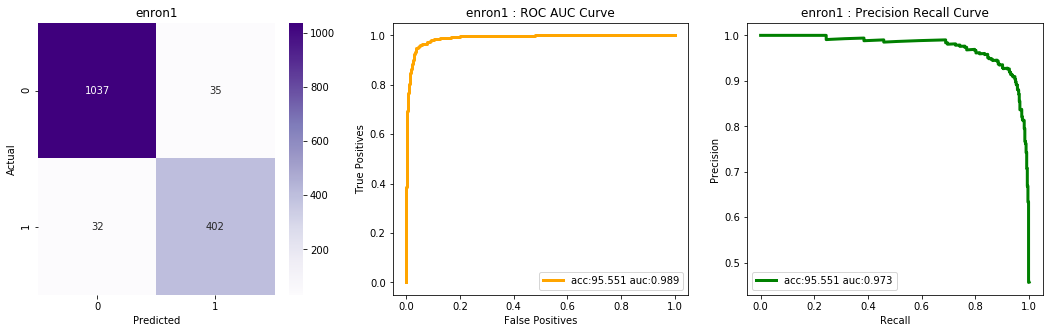

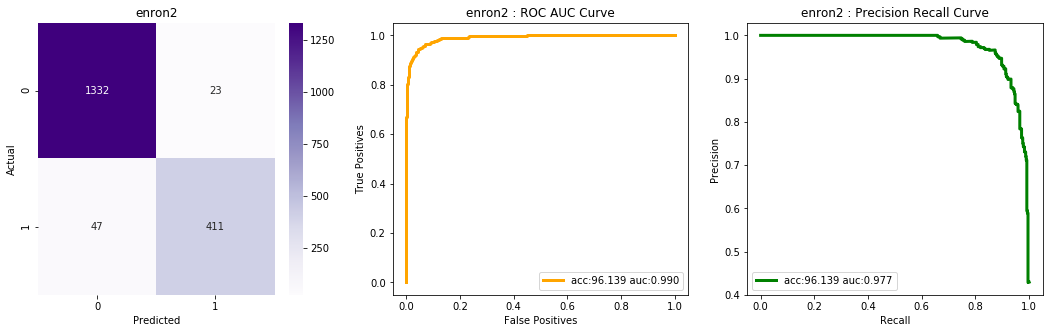

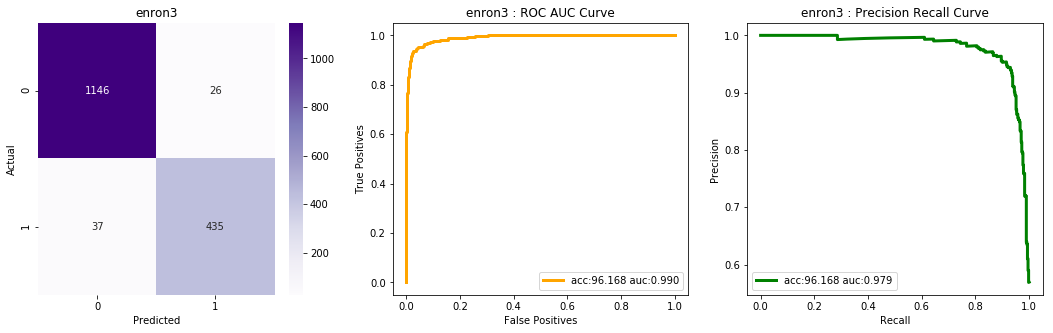

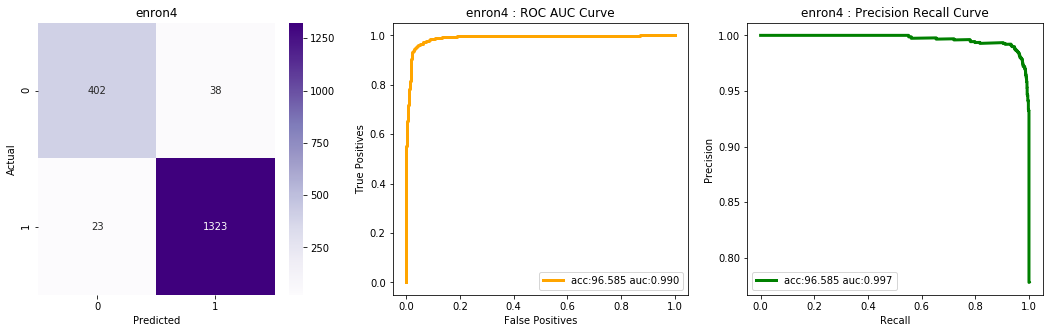

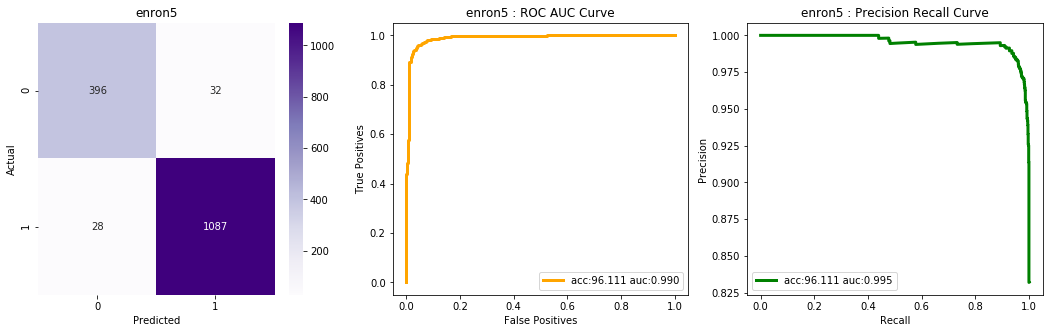

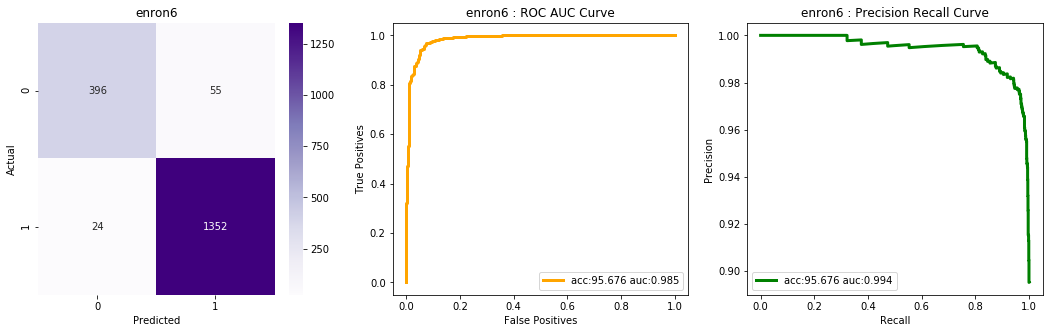

In [43]:
plot_all_evaluation_graphs(evaluated_metrics)

### 3.2.3 Check Taste Of Users
Below we loop through train datasets of each user and select 3 random spam mails. We then check prediction of model of other users on this mail to check whether these spam mails are spam for them as well or not.

In [44]:
check_taste_of_various_users(modified_datasets, all_users_train_test_data)

Selected 3 random mails from : enron1 test set.
Printing first 200 characters of mails to get idea about contents.
subject sunday alpha male plus multiple orgasm supplement men prevent premature ejacul
subject using claal somma vlcodd n vlaagrra zol ft allium xanaa codelne charset iso ob
subject president ceo dear sir joint venture would like apply medium co operation secu
Evaluating them on all users model
enron1 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron2 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron3 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron4 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron5 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
enron6 Model Predictions : [1. 1. 1.], True : [1. 1. 1.]
Selected 3 random mails from : enron2 test set.
Printing first 200 characters of mails to get idea about contents.
subject make thousand sending email easy yahoo com subject earn money sending e mail easy 
subject still wan na tried cialls yet eve

In [45]:
## No NAIVE BAYES for Embeddings because glove embeddings has negative values and Naive Bayes works on only positive values.
#params = {
#             'multinomialnb__alpha' : [0.1,0.5,1.0,]
#             }
#pipeline = make_pipeline(MultinomialNB())
#evaluated_metrics, modified_datasets = evaluate_model(params, pipeline, all_users_train_test_data, embedding=True, embedding_size=embedding_size)

In [46]:
#plot_all_evaluation_graphs(evaluated_metrics)

In [47]:
#check_taste_of_various_users(modified_datasets)